In [1]:
!pip install wandb
!pip install accelerate
!pip install bert_score
!pip install sacrebleu
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
# download hugging face datasets
import datasets
from datasets import concatenate_datasets
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sentencepiece
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import torch
import transformers
from datasets import load_dataset, load_metric
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer,DataCollatorForSeq2Seq,AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import wandb



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
train_Data = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
val_Data = datasets.load_dataset("wmt16","de-en", split="validation")
test_Data = datasets.load_dataset("wmt16","de-en", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

### Loading the model

In [4]:
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [6]:
pt_data = train_Data.map(preprocess_function, batched=True)
pt_data_v = val_Data.map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

In [7]:
model_config = dict(task = "2C",
                    model_name = "t5-small",
                    learning_rate = 2e-5,
                    per_device_train_batch_size = 16,
                    per_device_eval_batch_size = 16,
                    weight_decay = 0.01,
                    num_train_epochs = 5,
)
wandb.login(relogin=True)
# Initialize wandb
wandb.init(project="assignment-3", entity="nlp-assignments", name="t5-small_task2C_train_run", config=model_config)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vartika21571 (nlp-assignments). Use `wandb login --relogin` to force relogin


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    report_to="wandb",
    logging_dir='./logs',
    fp16=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print device information
print("Using device:", device)

# Set the device for the model and data
model.to(device)

# Run the code with the provided training arguments
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=pt_data,
    eval_dataset=pt_data_v,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

# Save the fine-tuned model
trainer.save_model("fine_tuned_t5_small_task2C")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.326300,2.099574
2,2.241800,2.062048
3,2.190100,2.045716
4,2.170100,2.034135
5,2.156900,2.031878


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


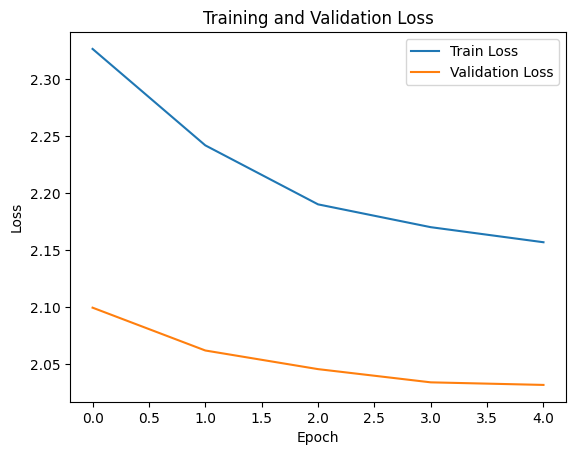

In [ ]:
import matplotlib.pyplot as plt

train_loss_indexes = []
train_loss = []
eval_loss = []
for i in range(len(trainer.state.log_history)):
    if "eval_loss" in trainer.state.log_history[i].keys():
        if trainer.state.log_history[i]['epoch']==1 or trainer.state.log_history[i]['epoch']==2 or trainer.state.log_history[i]['epoch']==3 or trainer.state.log_history[i]['epoch']==4 or trainer.state.log_history[i]['epoch']==5:
            train_loss_indexes.append(i-1)

for i in range(5):
    train_loss.append(trainer.state.log_history[train_loss_indexes[i]]['loss'])
    eval_loss.append(trainer.state.log_history[train_loss_indexes[i]+1]['eval_loss'])
# print(train_loss)
# print(eval_loss)



# Plot the graph
plt.plot(train_loss ,label='Train Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [10]:
import gc
torch.cuda.empty_cache()
gc.collect()

# Check memory usage
allocated_memory = torch.cuda.memory_allocated()
reserved_memory = torch.cuda.memory_reserved()

print("Allocated Memory:", allocated_memory / 1024**3, "GiB")
print("Reserved Memory:", reserved_memory / 1024**3, "GiB")

Allocated Memory: 0.0 GiB
Reserved Memory: 0.0 GiB


### Testing

In [11]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset, load_metric
from tqdm import tqdm

# Load the fine-tuned model
model_path = "/content/drive/MyDrive/fine_tuned_t5_small_task2C"  # Path to the saved fine-tuned model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Load the test dataset
test_dataset = load_dataset("wmt16", "de-en", split="test")

# Define the BLEU metric
bleu_metric = load_metric("sacrebleu")

# Generate translations for the test dataset
translations = []
references = []
for example in tqdm(test_dataset):
    input_text = "translate German to English: " + example["translation"]["de"]
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
    translated_ids = model.generate(input_ids, max_length=128, num_beams=4, early_stopping=True)
    translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
    translations.append(translated_text)
    references.append(example["translation"]["en"])



You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
<ipython-input-11-ab0fe135d1a4>:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for sacrebleu contains custom code which must be exe

100%|██████████| 2999/2999 [17:48<00:00,  2.81it/s]


In [ ]:
!pip install --upgrade nltk

import nltk
nltk.download('wordnet')


In [17]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# bleu_score_testing = corpus_bleu(references, translations)

# Calculate BLEU scores for individual n-gram orders (1-4) and all

def compute_bleu(reference_validation,translations_validation):
    w1 = [1, 0, 0, 0]
    w2 = [0.5, 0.5, 0, 0]
    w3 = [1/3, 1/3, 1/3, 0]
    w4 = [0.25, 0.25, 0.25, 0.25]
    bleu1 = corpus_bleu([[ref] for ref in reference_validation], translations_validation, weights=w1)
    bleu2 = corpus_bleu([[ref] for ref in reference_validation], translations_validation, weights=w2)
    bleu3 = corpus_bleu([[ref] for ref in reference_validation], translations_validation, weights=w3)
    bleu4 = corpus_bleu([[ref] for ref in reference_validation], translations_validation, weights=w4)
    print("BLEU-1 score for validation set:", bleu1)
    print("BLEU-2 score for validation set:", bleu2)
    print("BLEU-3 score for validation set:", bleu3)
    print("BLEU-4 score for validation set:", bleu4)


# Print BLEU scores
compute_bleu(references,translations)




# translations = ['hello']
# references = ['hello']

meteor = datasets.load_metric("meteor")
meteor_score = meteor.compute(predictions=translations, references=references)
print("METEOR score for testing set:", meteor_score)


from bert_score import score
P, R, F1 = score(translations, references, lang="de", verbose=True)
print("BERT Score for validation set:", F1.mean().item())

BLEU-1 score for validation set: 0.8279538607142208
BLEU-2 score for validation set: 0.728682425223939
BLEU-3 score for validation set: 0.6487978033927436
BLEU-4 score for validation set: 0.589032636540817


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR score for testing set: {'meteor': 0.5064402745439278}
calculating scores...
computing bert embedding.


  0%|          | 0/94 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 12.97 seconds, 231.25 sentences/sec
BERT Score for validation set: 0.8364496231079102


In [ ]:
# nltk.download("wordnet")